In [1]:
import ipynb

In [3]:
%run testsets.ipynb

In [4]:
%run evaluation.ipynb

In [8]:
import unicodedata
import re
import nltk
import itertools
import sklearn
import wordcloud
from nltk.collocations import BigramCollocationFinder
from nltk.metrics import BigramAssocMeasures
from nltk.classify import NaiveBayesClassifier, MaxentClassifier, SklearnClassifier
from sklearn.svm import LinearSVC, SVC
import matplotlib
import matplotlib.pyplot as pyplot
import wordcloud
from wordcloud import WordCloud, STOPWORDS

from sklearn.linear_model import LogisticRegression

In [9]:
def bag_of_words(words):
    return dict([(word, True) for word in words])

In [10]:
def wordcloud_draw(data, color = 'black'):
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2000,
                      height=1600,
                      max_words = 500,
                      normalize_plurals = False
                     ).generate_from_frequencies(data)
    pyplot.figure(1,figsize=(13, 13))
    pyplot.imshow(wordcloud)
    pyplot.axis('off')
    pyplot.show()

In [11]:
data = []

positive_bigrams_list = []
negative_bigrams_list = []
neutral_bigrams_list = []
positive_bigrams_list_draw = []
negative_bigrams_list_draw = []

In [12]:
with open('twitter-training-data.txt', 'r', encoding = 'utf-8') as twits:
    for line in twits:
            ## Lower case
            line = unicodedata.normalize('NFKC', line).encode('ASCII', 'ignore').lower()
            line = line.decode('utf-8')
            ## Separate every line by ID, sentiment and twitters
            mylist = line.split('\t')

            ## Remove \u002c and \u2019 and &amp
            mylist[2] = str(mylist[2]).replace(r"\u002c", ",")
            mylist[2] = mylist[2].replace(r"\u2019", "'")
            mylist[2] = mylist[2].replace(r"\u2019s", "'s")
            mylist[2] = mylist[2].replace("&amp", "&")
            ## Remove urls and retweets
            URL = re.compile(r'[https]+://[\S]+|[http]+://[\S]+|[www]+[.][\S]+[.][\S]+|[\S]+[.][\S]+|\b[RT]\b')
            mylist[2] = URL.sub(' ', mylist[2]) 
            ## Remove @ and #
            at_and_hashtag = re.compile(r'@[a-z0-9]+|#[a-z0-9]+')
            mylist[2] = at_and_hashtag.sub(' ', mylist[2]) 
            ## Remove elongated words
            mylist[2] = re.sub(r'(?i)(.)\1+',r'\1\1', mylist[2])
            ## Remove non alphanumeric charcters
            NONalphanum = re.compile('[^0-9a-z ]')
            mylist[2] = NONalphanum.sub(' ',mylist[2])
            ## Remove all-digit words
            ALL_digit = re.compile(r'\b\d+\b')
            mylist[2] = ALL_digit.sub(' ', mylist[2]) 

            mylist[2] = mylist[2].split(' ')         
        
            ## Remove stopwords(useless words)
            stopset = set(nltk.corpus.stopwords.words('english')) - set(('over', 'under', 'below', 'more', 'most', 'no', 'not', 'only', 'such', 'few', 'so', 'too', 'very', 'just', 'any', 'once'))
            #mylist[2] = list([i for i in nltk.word_tokenize(mylist[2]) if i not in stopset])
            mylist[2] = list([i for i in mylist[2] if i not in stopset])
                    
            mydic = {}
            mydic['ID'] = mylist[0]
            mydic['Sentiment'] = mylist[1]
            mydic['Content'] = mylist[2]
            ## Unigrams and bigrams
            myNgrams = itertools.chain(mylist[2], list(nltk.bigrams(mydic['Content'])), list(nltk.ngrams(mydic['Content'], 3)))
            ## In order to draw word clouds
            myNgrams2 = [''.join((x,y)) for (x,y) in list(nltk.bigrams(mydic['Content']))]


            if mydic['Sentiment'] == 'positive':
                    positive_bigrams_list.extend(myNgrams)
                    positive_bigrams_list_draw.extend(myNgrams2)
            elif mydic['Sentiment'] == 'neutral':
                    neutral_bigrams_list.extend(myNgrams)
            elif mydic['Sentiment'] == 'negative':
                    negative_bigrams_list.extend(myNgrams)
                    negative_bigrams_list_draw.extend(myNgrams2)
            data.append(mydic)

In [13]:
#positive_freqdist = nltk.FreqDist(positive_bigrams_list) 
positive_bigrams_list = [(bag_of_words(word), 'positive') for word in positive_bigrams_list]      
#negative_freqdist = nltk.FreqDist(negative_bigrams_list)
negative_bigrams_list = [(bag_of_words(word), 'negative') for word in negative_bigrams_list]
#neutral_freqdist = nltk.FreqDist(neutral_bigrams_list)
neutral_bigrams_list = [(bag_of_words(word), 'neutral') for word in neutral_bigrams_list]
train_set = positive_bigrams_list + negative_bigrams_list + neutral_bigrams_list


In [14]:
positive_bigrams_list_draw = {word: freq for (word, freq) in nltk.FreqDist(positive_bigrams_list_draw).most_common(1000)}
negative_bigrams_list_draw = {word: freq for (word, freq) in nltk.FreqDist(negative_bigrams_list_draw).most_common(1000)}

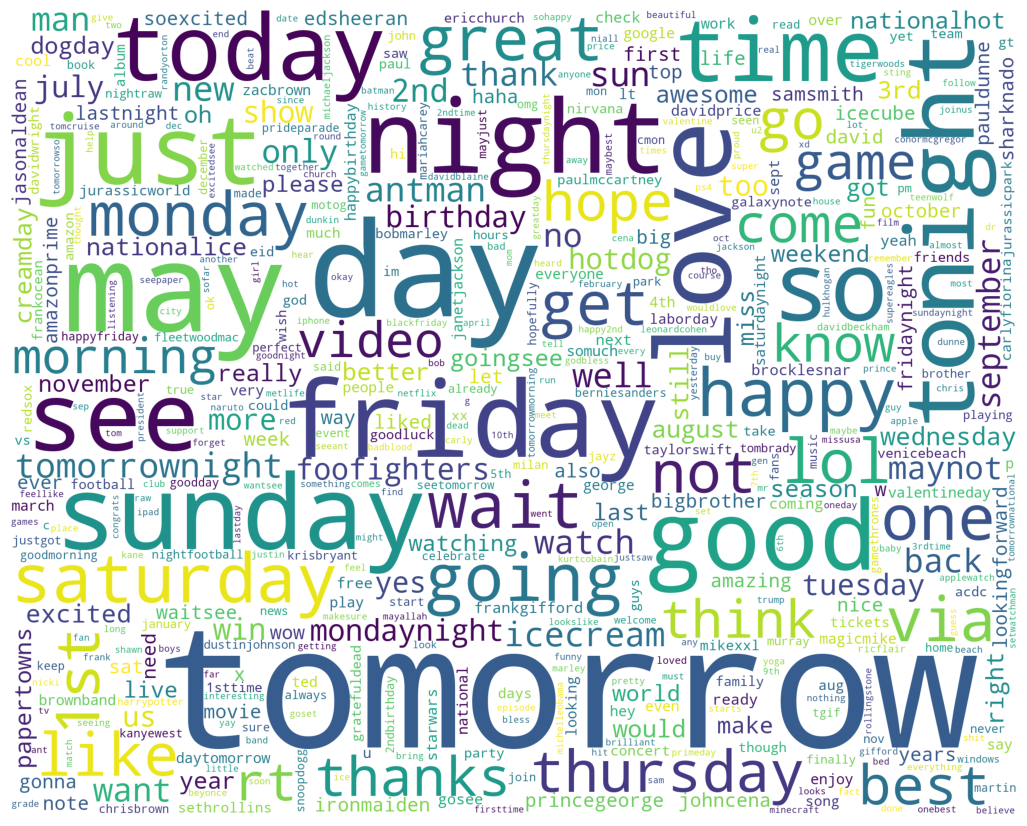

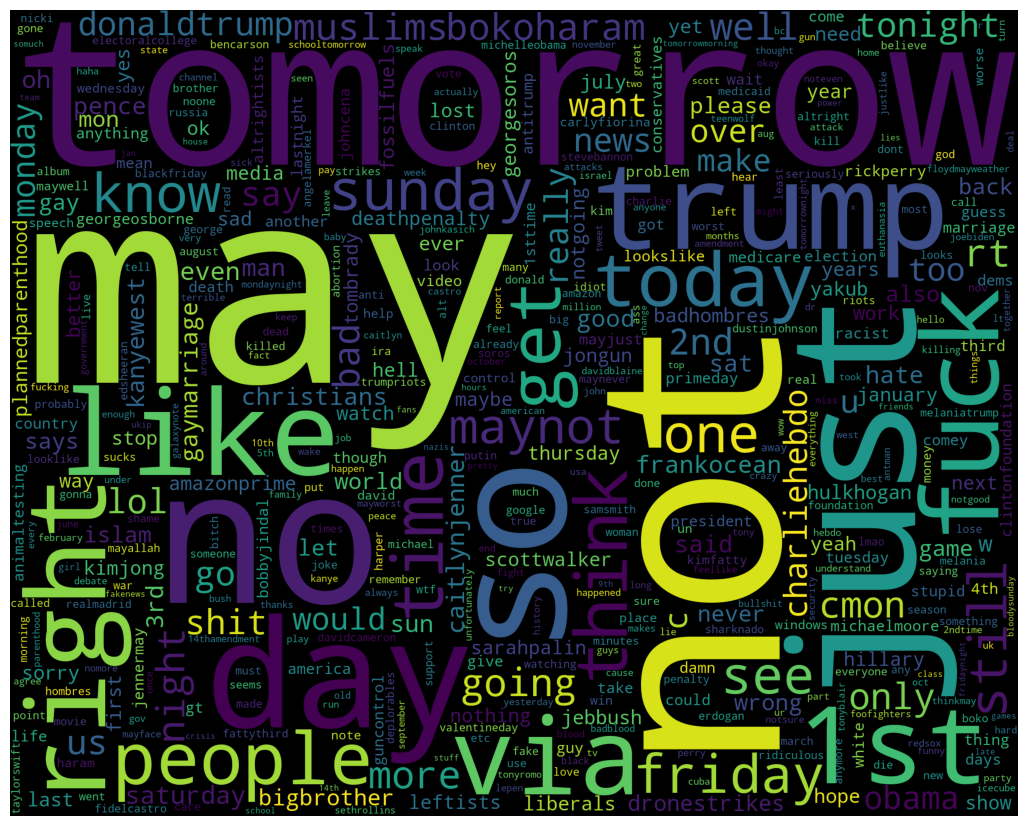

In [15]:
#### Untag it if wanting to plot word cloud
wordcloud_draw(positive_bigrams_list_draw, 'white')
wordcloud_draw(negative_bigrams_list_draw)

In [18]:
for classifier in ['NaiveBayesClassifier', 'MaxentClassifier', 'LogisticRegressionClassifier']: # You may rename the names of the classifiers to something more descriptive
    if classifier == 'NaiveBayesClassifier':
        print('Training ' + classifier)
        classifier_function = NaiveBayesClassifier.train(train_set)


    elif classifier == 'MaxentClassifier':
        print('Training ' + classifier)
        classifier_function = MaxentClassifier.train(train_set, 'GIS', trace=0, encoding=None, labels=None, gaussian_prior_sigma=0, max_iter = 1)

    elif classifier == 'LogisticRegressionClassifier':
        print('Training ' + classifier)
        classifier_function = SklearnClassifier(LogisticRegression())
        classifier_function.train(train_set)


    for testset in testsets:
        # TODO: classify tweets in test set
        with open(testset, 'r', encoding = 'utf-8') as twits:
            mynewlist = []
            mynewlist2 = []
            for line in twits:
                ## Lower case
                line = unicodedata.normalize('NFKC', line).encode('ASCII', 'ignore').lower()
                line = line.decode('utf-8')
                ## Separate every line by ID, sentiment and twitters
                mylist = line.split('\t')

                ## Remove \u002c and \u2019 and &amp
                mylist[2] = str(mylist[2]).replace(r"\u002c", ",")
                mylist[2] = mylist[2].replace(r"\u2019", "'")
                mylist[2] = mylist[2].replace(r"\u2019s", "'s")
                mylist[2] = mylist[2].replace("&amp", "&")
                ## Remove urls and retweets
                URL = re.compile(r'[https]+://[\S]+|[http]+://[\S]+|[www]+[.][\S]+[.][\S]+|[\S]+[.][\S]+|\b[RT]\b')
                mylist[2] = URL.sub(' ', mylist[2]) 
                ## Remove @ and #
                at_and_hashtag = re.compile(r'@[a-z0-9]+|#[a-z0-9]+')
                mylist[2] = at_and_hashtag.sub(' ', mylist[2]) 
                ## Remove elongated words
                mylist[2] = re.sub(r'(?i)(.)\1+',r'\1\1', mylist[2])
                ## Remove non alphanumeric charcters
                NONalphanum = re.compile('[^0-9a-z ]')
                mylist[2] = NONalphanum.sub(' ',mylist[2])
                ## Remove all-digit words
                ALL_digit = re.compile(r'\b\d+\b')
                mylist[2] = ALL_digit.sub(' ', mylist[2]) 

                mylist[2] = mylist[2].split(' ')         
            
                ## Remove stopwords(useless words)
                stopset = set(nltk.corpus.stopwords.words('english')) - set(('over', 'under', 'below', 'more', 'most', 'no', 'not', 'only', 'such', 'few', 'so', 'too', 'very', 'just', 'any', 'once'))
                #mylist[2] = list([i for i in nltk.word_tokenize(mylist[2]) if i not in stopset])
                mylist[2] = list([i for i in mylist[2] if i not in stopset])
                        
                new_ID = mylist[0]
                ## Unigrams and bigrams
                myNgrams = itertools.chain(mylist[2], list(nltk.bigrams(mylist[2])), list(nltk.ngrams(mylist[2], 3)))
                ## Classify new sentiment
                new_senti = classifier_function.classify(bag_of_words(myNgrams))
                mynewlist.append((new_ID, new_senti))
                mynewlist2.append((bag_of_words(myNgrams), new_senti))

        print ('accuracy:', nltk.classify.util.accuracy(classifier_function, mynewlist2))

        predictions = {key: value for (key, value) in mynewlist}

        evaluate(predictions, testset, classifier)

        confusion(predictions, testset, classifier)

Training NaiveBayesClassifier
accuracy: 0.4205607476635514
twitter-test1.txt (NaiveBayesClassifier): 0.518
            positive  negative  neutral
positive    0.582     0.076     0.343     
negative    0.201     0.533     0.266     
neutral     0.279     0.162     0.559     

accuracy: 0.3486238532110092
twitter-test2.txt (NaiveBayesClassifier): 0.521
            positive  negative  neutral
positive    0.664     0.070     0.266     
negative    0.299     0.408     0.293     
neutral     0.368     0.099     0.533     

accuracy: 0.44094157208911305
twitter-test3.txt (NaiveBayesClassifier): 0.494
            positive  negative  neutral
positive    0.602     0.084     0.314     
negative    0.274     0.416     0.310     
neutral     0.325     0.134     0.541     

Training MaxentClassifier
accuracy: 0.2087227414330218
twitter-test1.txt (MaxentClassifier): 0.242
            positive  negative  neutral
positive    0.726     0.062     0.212     
negative    0.000     0.000     0.000     
neu

/Users/lunalee/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


accuracy: 0.3659020107618238
twitter-test1.txt (LogisticRegressionClassifier): 0.571
            positive  negative  neutral
positive    0.600     0.072     0.329     
negative    0.179     0.564     0.257     
neutral     0.231     0.152     0.617     

accuracy: 0.2898003237992445
twitter-test2.txt (LogisticRegressionClassifier): 0.597
            positive  negative  neutral
positive    0.668     0.063     0.269     
negative    0.126     0.598     0.276     
neutral     0.320     0.095     0.585     

accuracy: 0.4047919293820933
twitter-test3.txt (LogisticRegressionClassifier): 0.564
            positive  negative  neutral
positive    0.635     0.074     0.291     
negative    0.233     0.500     0.267     
neutral     0.276     0.123     0.601     

